# 모델3 : 강철판

## 모델구성
- 

In [34]:
# Tensorflow Check
import tensorflow as tf
from tensorflow.python.client import device_lib
import sys
print(f'Python     : {sys.version.split("|")[0]}')
print(f'Tensorflow : {tf.__version__}')
print(f'TF GPU     : {"True" if device_lib.list_local_devices()[1] else "False"}')

Python     : 3.10.11 
Tensorflow : 2.10.1
TF GPU     : True


In [35]:
# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score

from tensorflow import keras
from IPython.display import clear_output
import json

# 각종 변수 선언
csv_path = 'D:/coding/aib/GPTeachersDay/TeamProject1/leeyeonjun/Data/mulit_classification_data.csv'
EPOCHS = 1000
MB_SIZE = 2048

In [36]:
# 필요한 함수 / 메소드 정의
class CustomCallback(keras.callbacks.Callback):
    """
    사용자 정의 콜백함수
    """
    def on_train_begin(self, logs=None):
        print("Starting training")

    def on_train_end(self, logs=None):
        print("End training")
        # clear_output(wait=True)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 100 == 0:print()
        if epoch % 10 == 0:
            print(f'{epoch} / ', end='')

def load_data(csv_path, TRAIN_RATIO=0.8):
    
        # 데이터셋 로드
    df = pd.read_csv(csv_path)
    
    # 인코딩 방식 변경
    # idxmax 함수는 각 행의 최대값을 가진 열의 인덱스를 반환한다. 따라서 원핫인코딩된 피쳐를 하나의 카테고리 변수로 복원할 수 있음
    df['Fault'] = df[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']].idxmax(axis=1)
    
    # 라벨 인코딩(원핫인코딩보다 차원수가 줄어드는 효과)
    encoder = LabelEncoder()
    df['Fault'] = encoder.fit_transform(df['Fault'])
    
    # 학습 데이터 분리
    X = df.drop(['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults', 'Fault'], axis=1)
    y = df['Fault']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_RATIO, random_state = 83)
    
    # 스케일링할 피처 선택
    scaling_features = X_train.columns

    # 스케일링
    scaler = MinMaxScaler()
    X_train_org = X_train.copy()  # 원본 데이터 복사
    X_test_org = X_test.copy()    # 원본 데이터 복사
    X_train[scaling_features] = scaler.fit_transform(X_train[scaling_features])
    X_test[scaling_features] = scaler.transform(X_test[scaling_features])
    
    return X, y, X_train, X_test, y_train, y_test, df, encoder

def get_model(shape, dout=0.01, output_bias=None):
    
    np.random.seed(83)
    tf.random.set_seed(83)
    
    regularizer=keras.regularizers.L1L2(l1=0.001, l2=0.001)
    
    inputs  = keras.Input(shape=shape)

    dense1  = keras.layers.Dense(8, kernel_regularizer=regularizer)(inputs)
    norm1   = keras.layers.BatchNormalization()(dense1)
    relu1   = keras.layers.Activation('relu')(norm1)
    dout1   = keras.layers.Dropout(dout)(relu1)
    
    dense2  = keras.layers.Dense(7, kernel_regularizer=regularizer)(dout1)
    norm2   = keras.layers.BatchNormalization()(dense2)
    relu2   = keras.layers.Activation('relu')(norm2)
    dout2   = keras.layers.Dropout(dout)(relu2)
    
    dense3  = keras.layers.Dense(6, kernel_regularizer=regularizer)(dout2)
    norm3   = keras.layers.BatchNormalization()(dense3)
    relu3   = keras.layers.Activation('relu')(norm3)
    dout3   = keras.layers.Dropout(dout)(relu3)
    
    dense4  = keras.layers.Dense(5, kernel_regularizer=regularizer)(dout3)
    norm4   = keras.layers.BatchNormalization()(dense4)
    relu4   = keras.layers.Activation('relu')(norm4)
    dout4   = keras.layers.Dropout(dout)(relu4)
    
    dense5  = keras.layers.Dense(4, kernel_regularizer=regularizer)(dout4)
    norm5   = keras.layers.BatchNormalization()(dense5)
    relu5   = keras.layers.Activation('relu')(norm5)
    dout5   = keras.layers.Dropout(dout)(relu5)
    
    concat1  = keras.layers.Concatenate(axis=1)([dout5, dout4])
    dense6  = keras.layers.Dense(5, kernel_regularizer=regularizer)(concat1)
    norm6   = keras.layers.BatchNormalization()(dense6)
    relu6   = keras.layers.Activation('relu')(norm6)
    dout6   = keras.layers.Dropout(dout)(relu6)
    
    concat2  = keras.layers.Concatenate(axis=1)([dout6, dout3])
    dense7  = keras.layers.Dense(6, kernel_regularizer=regularizer)(concat2)
    norm7   = keras.layers.BatchNormalization()(dense7)
    relu7   = keras.layers.Activation('relu')(norm7)
    dout7   = keras.layers.Dropout(dout)(relu7)
    
    concat3  = keras.layers.Concatenate(axis=1)([dout7, dout2])
    dense8  = keras.layers.Dense(7, kernel_regularizer=regularizer)(concat3)
    norm8   = keras.layers.BatchNormalization()(dense8)
    relu8   = keras.layers.Activation('relu')(norm8)
    dout8   = keras.layers.Dropout(dout)(relu8)
    
    concat4  = keras.layers.Concatenate(axis=1)([dout8, dout1])
    dense9  = keras.layers.Dense(8, kernel_regularizer=regularizer)(concat4)
    norm9   = keras.layers.BatchNormalization()(dense9)
    relu9   = keras.layers.Activation('relu')(norm9)
    dout9   = keras.layers.Dropout(dout)(relu9)
    
    outputs = keras.layers.Dense(1, activation='sigmoid'
                                 , bias_initializer=output_bias)(dout9)
    model   = keras.Model(inputs, outputs, name='Star_Model')
    
    METRICS = [
            keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc'),
            ]
    
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=METRICS
        )
    return model

In [37]:
X, y, X_train, X_test, y_train, y_test, df, encoder = load_data(csv_path)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train.describe()

(1552, 27) (389, 27) (1552,) (389,)


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
count,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,...,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000
mean,0.330774,0.356441,0.126574,0.126577,0.013108,0.011009,0.004751,0.018771,0.428144,0.432948,...,0.037632,0.597720,0.797034,0.575709,0.393919,0.336539,0.281349,0.539658,0.544567,0.535582
std,0.305080,0.290613,0.135898,0.135898,0.036294,0.031247,0.026128,0.046750,0.162898,0.084864,...,0.071875,0.246366,0.248450,0.483349,0.180612,0.187544,0.115831,0.255834,0.091082,0.389066
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029326,0.110445,0.036023,0.036025,0.000524,0.001149,0.000661,0.000781,0.316327,0.404651,...,0.005036,0.391234,0.567255,0.000000,0.262467,0.201348,0.196629,0.315832,0.505753,0.145342
50%,0.233138,0.258046,0.092082,0.092089,0.001127,0.002393,0.001322,0.001637,0.459184,0.418605,...,0.009271,0.624188,0.936318,1.000000,0.334173,0.269157,0.263133,0.549957,0.544606,0.461662
75%,0.615249,0.621416,0.168545,0.168544,0.006124,0.008711,0.004683,0.007855,0.540816,0.479070,...,0.025295,0.797078,1.000000,1.000000,0.498303,0.410859,0.367613,0.759444,0.586540,0.999886
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [38]:
model = get_model(len(X_train.columns))
# keras.utils.plot_model(model, show_shapes=True, to_file='model2_model.png')

In [39]:
# 얼리스타핑
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss'
                                        , min_delta=0.000001
                                        , mode='auto'
                                        , patience=EPOCHS//2)

# 모델 저장
checkpoint_path = './model3.h5'
checkpoint = keras.callbacks.ModelCheckpoint(
                                        checkpoint_path
                                        , monitor='val_loss'
                                        , verbose=0
                                        , mode = 'auto'
                                        , save_best_only=True
                                        , save_weights_only=True)

# 학습률 조정
lr_decay = keras.optimizers.schedules.CosineDecay(
                                        initial_learning_rate=0.01
                                        , decay_steps=EPOCHS
                                        , alpha=1e-16)
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# 모델 학습
history = model.fit(X_train, y_train
                , batch_size=MB_SIZE
                , validation_split = 0.2
                , verbose=0
                , epochs=EPOCHS
                , callbacks=[earlystop, checkpoint, CustomCallback(), lr_scheduler]
                )

Starting training

0 / 10 / 20 / 30 / 40 / 50 / 60 / 70 / 80 / 90 / 
100 / 110 / 120 / 130 / 140 / 150 / 160 / 

In [ ]:
# 가장 성능이 좋았던 모델을 가져와 평가
model.load_weights(checkpoint_path)
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)
results = model.evaluate(X_test, y_test)
print(f'Test Loss : {results[0]:.3f} / Accuracy: {results[1]:.3f} ')

13/13 [==============================] - 0s 5ms/step - loss: 1.0064 - accuracy: 0.7661
Test Loss : 1.006 / Accuracy: 0.766 


In [ ]:
import json
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist = hist.set_index('epoch')
hist.to_json('model3.json')

In [ ]:
with open('model3.json') as json_file:
    json_file = json.loads(json_file.read())
model1_hist = pd.DataFrame(json_file)
model1_hist

,loss,accuracy,val_loss,val_accuracy,lr
0,81.268440,0.343272,99.137787,0.192926,1.000000e-03
1,101.600967,0.210314,83.596756,0.356913,1.000000e-03
2,85.098206,0.269138,77.761009,0.315113,1.000000e-03
3,78.511848,0.260274,74.424644,0.334405,1.000000e-03
4,74.782158,0.290089,72.062431,0.347267,1.000000e-03
...,...,...,...,...,...
995,0.494394,0.925866,1.091145,0.765273,2.621440e-16
996,0.511825,0.914585,1.091145,0.765273,2.621440e-16
997,0.497161,0.921837,1.091145,0.765273,2.621440e-16
998,0.493482,0.924255,1.091145,0.765273,2.621440e-16


In [ ]:
model1_hist.sort_values(by=['val_loss'], ascending=True).iloc[:5,:]

,loss,accuracy,val_loss,val_accuracy,lr
549,0.569289,0.899275,0.999657,0.733119,0.001
466,0.650890,0.869460,1.007848,0.758842,0.001
545,0.581895,0.887188,1.010417,0.742765,0.001
544,0.657243,0.843674,1.013099,0.755627,0.001
548,0.599825,0.873489,1.014257,0.749196,0.001


13/13 [==============================] - 0s 2ms/step


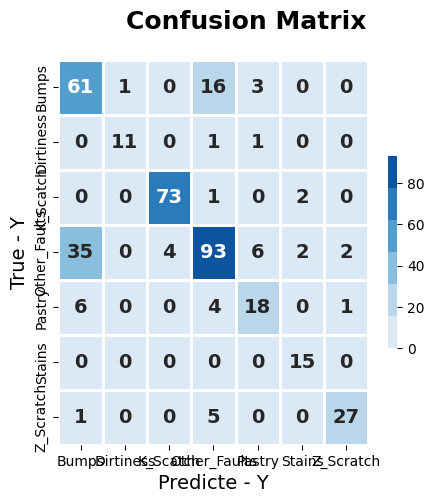

In [ ]:
c_mat = confusion_matrix(y_test, tf.math.argmax(model.predict(X_test), axis=1))

# 히트맵을 그린다
fig, ax = plt.subplots(figsize=(5,5))
fig.suptitle('Confusion Matrix', fontsize = 18, fontweight = 'bold')
sns.heatmap(c_mat, 
            cmap = sns.color_palette('Blues'), 
            annot = True,
            annot_kws = {'fontweight':'bold','size':14},
            fmt=',.0f',
            linewidths = 2,
            cbar_kws = {'shrink': .5},
           )

ax.xaxis.set_ticklabels(encoder.classes_)
ax.yaxis.set_ticklabels(encoder.classes_)
plt.xlabel('Predicte - Y', fontsize = 14)
plt.ylabel('True - Y', fontsize = 14)
plt.show()

fig.savefig('model3_cm.png', dpi=80, bbox_inches='tight')

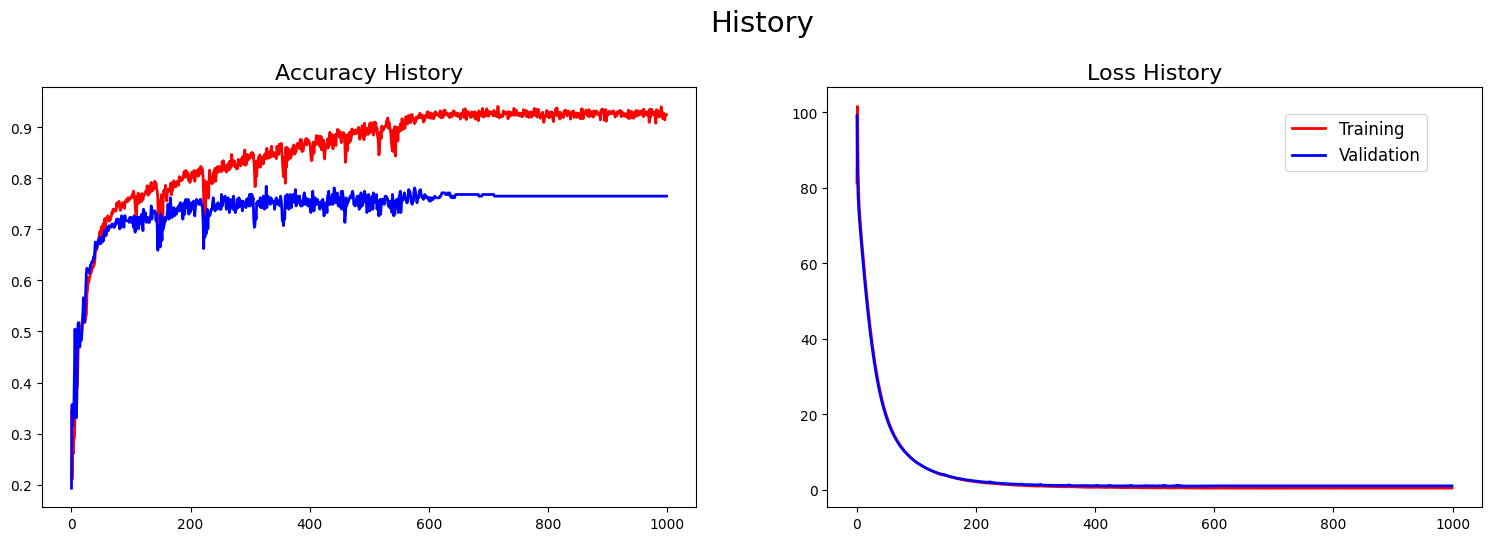

In [ ]:
fig = plt.figure(figsize=(16, 6))
fig.suptitle('History', fontsize = 21)

# Accuracy Plot
ax = plt.subplot(1, 2, 1)
plt.title(f'Accuracy History', fontsize = 16, y = 1)
plt.plot(history.history["accuracy"], color='r', linewidth=2, label="Training")
plt.plot(history.history["val_accuracy"], color='b', linewidth=2, label="Validation")

# Loss Plot
ax = plt.subplot(1, 2, 2)
plt.title(f'Loss History', fontsize = 16, y = 1)
plt.plot(history.history["loss"], color='r', linewidth=2, label="Training")
plt.plot(history.history["val_loss"], color='b', linewidth=2, label="Validation")

plt.legend(fontsize=12, loc=(0.7, 0.8))
plt.subplots_adjust(right=0.95, left=0.05, top=0.85, bottom=0.15, wspace=0.2, hspace=0.2)
plt.show()

fig.savefig('model3_history.png', dpi=80, bbox_inches='tight')